    Danai Zacharioudaki 9418                                           
    Stergios Grigoriou  9564                                     grigster@ece.auth.gr

In [2]:
import os

import keras.constraints
import numpy as np
import sklearn.preprocessing
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerTuple
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn import svm

In [3]:
class my_Bayes_Model:
    #class for creating Bayes models using MLE on train data
    def __init__(self,dif_covmat=False):
        self.dif_covmat = dif_covmat#boolean determining if the model assumes different covariance matrix for each class or not (defaults to creating models with the same cov_matrix) 
        self.un_labels = []#unique labels of the model
        self.mu = []#mean values of each feature for each class label in un_labels
        self.covmat = []#list of covariance matrices of the feature vectors 
        self.aprior = []#apriori class probabilities
    def train(self,features,labels):
        #method for fitting the model to some data
        #features are the feature vectors columnwise (2D-np.array)
        #labels are the class labels corresponding to the features array
        self.un_labels = np.unique(labels)
        self.mu = [np.mean(features[labels==self.un_labels[i]],0) for i in range(len(self.un_labels))]
        self.aprior = [np.sum(y==self.un_labels[i])/len(y) for i in range(len(self.un_labels))]
        if self.dif_covmat:
        #calculating the covariance matrix of the feature vectors for each class
            self.covmat = [np.cov(features[labels==self.un_labels[i]],rowvar=False,bias=True) for i in range(len(self.un_labels))]
        else:
        #calculating the covariance matrix of the feature vectors
            self.covmat = np.cov(features,rowvar=False,bias=True)
    def predict(self,test_data):
        #method for predicting the labels of given data
        #test_data must have the same number of columns as the self.mu[i] vector
        if self.dif_covmat:
            invcov = [np.linalg.inv(self.covmat[i]) for i in range(len(self.covmat))]
            g = np.array([[-0.5*np.transpose(test_data[j]-self.mu[i])@invcov[i]@(test_data[j]-self.mu[i]) + np.log(self.aprior[i])\
                           for i in range(len(self.mu))] for j in range(len(test_data))])#calculating the value of each discriminant function
        else:
            invcov = np.linalg.inv(self.covmat)
            g = np.array([[-0.5*np.transpose(test_data[j]-self.mu[i])@invcov@(test_data[j]-self.mu[i]) + np.log(self.aprior[i])\
                           for i in range(len(self.mu))] for j in range(len(test_data))])#calculating the value of each discriminant function
        y_hat = self.un_labels[np.argmax(g,1)]#estimations (max disc value)
        return y_hat
# def seq_model(layer_arg=(512,0.4,256,0.2),layer_type=('D','Do','D','Do'),L2pen=None,model_name='2_Hidden_Layer_Dense_with_Dropout'):
#     #For more compact and repetitive model creation
#     model_out = tf.keras.Sequential(name= model_name)
#     model_out.add(tf.keras.layers.Input(shape=(400,)))
#     model_out.add(tf.keras.layers.BatchNormalization())
#     for layer in range(len(layer_arg)):
#         if layer_type[layer] == 'D':
#             if L2pen is not None:
#                 model_out.add(tf.keras.layers.Dense(layer_arg[layer], activation="relu",kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.L2(L2pen)))
#             else:
#                 model_out.add(tf.keras.layers.Dense(layer_arg[layer], activation="relu",kernel_initializer='glorot_normal'))
#         elif layer_type[layer] == 'S':
#             model_out.add(Sparse(layer_arg[layer][0],layer_arg[layer][1]))
#         elif layer_type[layer] == 'Do':
#             model_out.add(tf.keras.layers.Dropout(layer_arg[layer]))
#         else:
#             raise Exception("Supported layer types are Dense(D),Sparse(S),Dropout") 
#     model_out.add(tf.keras.layers.Dense(5,activation='softmax'))
#     return model_out
# 
# 
# def train_model(Xs,ys,model_type,kN=0):
#     #Xs and ys are the train set
#     #model_type can be either 'NN' or 'nearest_centroid'
#     #k is the k parameter (number of neighbours) for the k-NN model
#     model_name = ''
#     modele = KNeighborsClassifier(n_neighbors=kN, algorithm='brute')
#     t = time.time()#for runtime estimation
#     #fitting the model to the train data
#     if model_type == 'NN':
#         modele = KNeighborsClassifier(n_neighbors=kN, algorithm='brute')
#         modele.fit(Xs,ys)
#         t = time.time() - t
#         model_name = ('%d-NN'% kN)
#     elif model_type == 'nearest_centroid':
#         modele = NearestCentroid()
#         modele.fit(Xs, ys)
#         t = time.time() - t
#         model_name = 'Nearest Centroid'
#     else:
#         print('Wrong model_type input. Acceptable values\nare: "NN" or "nearest_centroid".')
#     print('%s:'% model_name)
#     print('Training time elapsed: %.2f ms.'%(1000*t))
#     return modele,model_name
# 
# 
# def evaluate_model(modele,Xs,ys,model_name,label_names):
#     #model is the sklearn classification model object for evaluation
#     #Xs ys are the validation or test data
#     #model_name is the name of the model
#     #Predicting the classes of the test Xs
#     t = time.time()#for calculating prediction time
#     y_hat = modele.predict(Xs)
#     if len(y_hat.shape) > 1:
#         y_hat = np.argmax(y_hat,1)
#     t = time.time() - t
#     print('Prediction time elapsed: %.2f ms.' % (1000 * t))
#     #Calculating recall and precision class wise
#     recall = mt.recall_score(ys, y_hat, average=None)
#     precision = mt.precision_score(ys, y_hat, average=None)
#     # Calculating class wise f1_score
#     f1 = 2*recall*precision/(recall+precision)
#     #Calculating average (macro) accuracy of the model
#     accu = np.sum(np.equal(ys,y_hat))/len(ys)#or just the np.mean(recall)
#     print('Accuracy: %.4f'% accu)
#     df = np.vstack((recall,precision))
#     df = np.vstack((df,f1))
#     avrgs = np.zeros((3,1))
#     avrgs[2] = np.mean(f1)
#     avrgs[1] = np.mean(precision)
#     avrgs[0] = np.mean(recall)
#     df = np.hstack((df,avrgs))
#     label_names = np.hstack((label_names,'average'))
#     daf = pd.DataFrame(data=df,index=['recall','precision','f1'],columns=label_names)
#     print(daf.to_string())
#     print('\n\n')
#     #Calculating and plotting the confusion matrix of the model on the val/test data
#     cm = mt.confusion_matrix(ys, y_hat)
#     disp = mt.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names[0:10])
#     disp.plot()
#     plt.title(model_name)
#     plt.show()
#     return recall, precision, f1

def learning_curves(hist_obj,title_str='some model',saving=False,saving_path='',metric_name='categorical_accuracy',loss_name='cross entropy'):
    #This function is used to plot/save the learning_curves of the various mlp models that where trained
    #It take as input: a tf.keras.callbacks.History() object 
    #                : the tile of the model 
    #                : a logical value that determines if the plot will also be saved
    #                : the saving directory 
    #                : the name of the metric we want to plot. (must be in the list of the metrics that were calculated during the creation of the object)
    #                : the name of the loss function we want to plot. 
    train_lss = hist_obj.history['loss']
    val_lss = hist_obj.history['val_loss']
    train_metric = hist_obj.history[metric_name]
    val_metric = hist_obj.history['val_'+metric_name]
    epochs = np.linspace(1,len(train_lss),len(train_lss))
    plt.plot(epochs,train_lss,label='Training')
    plt.plot(epochs,val_lss,label='Validation')
    plt.xlabel('epochs')
    plt.ylabel(loss_name)
    plt.legend()
    plt.title('Loss curve of '+title_str)
    if saving:
        plt.savefig(os.path.join(saving_path,'loss_curve_of'+title_str+'.csv'))
    plt.show()
    plt.plot(epochs,train_metric,label='Training')
    plt.plot(epochs,val_metric,label='Validation')
    plt.xlabel('epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title('Metric curve of '+title_str)
    if saving:
        plt.savefig(os.path.join(saving_path,'metric_curve_of'+title_str+'.csv'))
    plt.show()
    
    
def gridsearch(Xs, ys, cv=5, kernel='rbf', C=2.0 ** np.arange(start=-5, stop=17, step=2), gamma=None, degree=None, p=False):
    # Function for SVM hyperparameter tuning through cross validation
    grid_params = {}
    if hasattr(kernel, '__len__') and (not isinstance(kernel, str)):
        grid_params.update({'kernel': kernel})
    else:
        grid_params.update({'kernel': [kernel]})
    if hasattr(C, '__len__'):
        grid_params.update({'C': C})
    else:
        grid_params.update({'C': [C]})
    if hasattr(gamma, '__len__') and gamma is not None:
        grid_params.update({'gamma': gamma})
    elif gamma is not None:
        grid_params.update({'gamma': [gamma]})
    if hasattr(degree, '__len__') and degree is not None:
        grid_params.update({'degree': degree})
    elif degree is not None:
        grid_params.update({'degree': [degree]})
    if kernel == 'linear':
        del grid_params['kernel']
        cvSVM = GridSearchCV(svm.LinearSVC(dual='auto'), grid_params, scoring='accuracy', verbose=1, cv=cv, n_jobs=-1)
    else:
        cvSVM = GridSearchCV(svm.SVC(cache_size=1999), grid_params, scoring='accuracy', verbose=100, cv=cv, n_jobs=-1)
    cvSVM.fit(Xs, ys)
    if p:
        bp = cvSVM.best_params_
        print(bp)
    return cvSVM

In [4]:
mypath = 'C:/Users/grist/Desktop/Pattern/'#You can change this variable to the directory of the folder that contains the dataset
data = np.loadtxt(os.path.join(mypath,'datasetC.csv'), delimiter=',', dtype=np.float64)
X_test = np.loadtxt(os.path.join(mypath,'datasetCTest.csv'), delimiter=',', dtype=np.float64)

In [5]:
X = data[:,0:400]
y = data[:,400]
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=73)#Spliting the dataset into train and validation sets.

In [25]:
# X_train_tf = tf.convert_to_tensor(X_train_s)
# X_val_tf = tf.convert_to_tensor(X_val_s)
# y_train_one_hot = tf.one_hot(y_train,len(np.unique(y_train)))
# y_val_one_hot = tf.one_hot(y_val,len(np.unique(y_train)))

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
pipe = Pipeline(
    [
        ("scaling", StandardScaler()),
        # the reduce_dim stage is populated by the param_grid
        ("reduce_dim", "passthrough"),
        ("classify", svm.SVC(kernel='rbf',cache_size=1000)),
    ]
)
Cval = 2.0**np.arange(start=-5,stop=17,step=2)
gammaval = 2.0**np.arange(start=-15,stop=5,step=0.25)
var_explained = [PCA(0.8),PCA(0.95),None]
params = {
        "reduce_dim": var_explained,
        "classify__C": Cval,
        "classify__gamma": gammaval
    }

In [29]:
CVRBF_ALL = GridSearchCV(pipe,params,scoring='accuracy',verbose=300,n_jobs=-1)
CVRBF_ALL.fit(X,y)

Fitting 5 folds for each of 2640 candidates, totalling 13200 fits


GridSearchCV(estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify', SVC(cache_size=1000))]),
             n_jobs=-1,
             param_grid={'classify__C': array([3.1250e-02, 1.2500e-01, 5.0000e-01, 2.0000e+00, 8.0000e+00,
       3.2000e+01, 1.2800e+02, 5.1200e+02, 2.0480e+03, 8.1920e+03,
       3.2768e+04]),
                         'classify__gamma': array([3.05175781e-05, 3.62917210e...
       1.00000000e+00, 1.18920712e+00, 1.41421356e+00, 1.68179283e+00,
       2.00000000e+00, 2.37841423e+00, 2.82842712e+00, 3.36358566e+00,
       4.00000000e+00, 4.75682846e+00, 5.65685425e+00, 6.72717132e+00,
       8.00000000e+00, 9.51365692e+00, 1.13137085e+01, 1.34543426e+01,
       1.60000000e+01, 1.90273138e+01, 2.26274170e+01, 2.69086853e+01]),
                         'reduce_dim': [PCA(n_components=0.8),
                                        PCA(n_components=0.95), None]},
             scoring='accuracy', verbose=300)

In [30]:
from pandas import DataFrame as df
cv_rbf_all = df(CVRBF_ALL.cv_results_)
cv_rbf_all

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classify__C,param_classify__gamma,param_reduce_dim,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,18.246612,0.150187,3.151574,0.059293,0.03125,0.000031,PCA(n_components=0.8),"{'classify__C': 0.03125, 'classify__gamma': 3....",0.226,0.226,0.226,0.226,0.225,0.2258,0.0004,1091
1,21.652306,0.720111,4.333413,0.091488,0.03125,0.000031,PCA(n_components=0.95),"{'classify__C': 0.03125, 'classify__gamma': 3....",0.226,0.226,0.226,0.226,0.225,0.2258,0.0004,1091
2,23.178026,0.275668,4.652960,0.192761,0.03125,0.000031,None,"{'classify__C': 0.03125, 'classify__gamma': 3....",0.226,0.226,0.226,0.226,0.225,0.2258,0.0004,1091
3,18.004459,0.345813,3.379173,0.121815,0.03125,0.000036,PCA(n_components=0.8),"{'classify__C': 0.03125, 'classify__gamma': 3....",0.226,0.226,0.226,0.226,0.225,0.2258,0.0004,1091
4,22.624651,2.117411,5.206100,0.693719,0.03125,0.000036,PCA(n_components=0.95),"{'classify__C': 0.03125, 'classify__gamma': 3....",0.226,0.226,0.226,0.226,0.225,0.2258,0.0004,1091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,26.853995,0.431838,5.382788,0.233106,32768.0,22.627417,PCA(n_components=0.95),"{'classify__C': 32768.0, 'classify__gamma': 22...",0.226,0.226,0.226,0.226,0.225,0.2258,0.0004,1091
2636,27.873748,0.455026,6.062863,0.313304,32768.0,22.627417,None,"{'classify__C': 32768.0, 'classify__gamma': 22...",0.226,0.226,0.226,0.226,0.225,0.2258,0.0004,1091
2637,23.174534,0.295614,4.305100,0.231649,32768.0,26.908685,PCA(n_components=0.8),"{'classify__C': 32768.0, 'classify__gamma': 26...",0.226,0.226,0.226,0.226,0.225,0.2258,0.0004,1091
2638,27.321843,0.469695,5.412551,0.181543,32768.0,26.908685,PCA(n_components=0.95),"{'classify__C': 32768.0, 'classify__gamma': 26...",0.226,0.226,0.226,0.226,0.225,0.2258,0.0004,1091


In [55]:
pipe2 = Pipeline(
    [
        # the reduce_dim stage is populated by the param_grid
        ("reduce_dim", PCA(0.8)),
        ("classify", svm.SVC(kernel='rbf',cache_size=1000,class_weight='balanced')),
    ]
)
Cbest = 8
gammabest = 2.0**(-8)
param_grid_best = {
        "classify__C": [Cbest],
        "classify__gamma": [gammabest]
    }
cvrbf = GridSearchCV(pipe2,param_grid_best,scoring='accuracy',verbose=300,n_jobs=-1)

In [56]:
cvrbf.fit(X,y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(estimator=Pipeline(steps=[('reduce_dim', PCA(n_components=0.8)),
                                       ('classify',
                                        SVC(cache_size=1000,
                                            class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'classify__C': [8], 'classify__gamma': [0.00390625]},
             scoring='accuracy', verbose=300)

In [57]:
cv_rbf = df(cvrbf.cv_results_)
cv_rbf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classify__C,param_classify__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,9.124289,0.204356,1.488227,0.071093,8,0.003906,"{'classify__C': 8, 'classify__gamma': 0.00390625}",0.837,0.866,0.861,0.83,0.86,0.8508,0.014442,1


In [53]:
skf = StratifiedKFold(shuffle=True,random_state=73,n_splits=5)
acc_diff = np.zeros((5,))
acc_same = np.zeros((5,))
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    model= my_Bayes_Model(True)
    model_s = my_Bayes_Model()
    model.train(X[train_index],y[train_index])
    model_s.train(X[train_index],y[train_index])
    y_diff = model.predict(X[test_index])
    corr_class_diff = y_diff == y[test_index]
    acc_diff[i] = np.sum(corr_class_diff)/len(y[test_index])
    y_s = model_s.predict(X[test_index])
    corr_class_s = y_s == y[test_index]
    acc_same[i] = np.sum(corr_class_s)/len(y[test_index])

In [58]:
print(acc_diff)
print(acc_same)
print(np.mean(acc_same))

[0.447 0.469 0.451 0.45  0.448]
[0.792 0.815 0.786 0.811 0.8  ]
0.8008


In [75]:
param_grid_best_iter = {
        "classify__C": [Cbest],
        "classify__gamma": [gammabest],
        "classify__max_iter": [250,750,1500,2000],
        "reduce_dim":[PCA(0.8)]
    }
cvrbfiter = GridSearchCV(pipe,param_grid_best_iter,scoring='accuracy',verbose=300,n_jobs=-1)

In [76]:
cvrbfiter.fit(X,y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\grist\anaconda3\envs\ml_nn\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=750).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify', SVC(cache_size=1000))]),
             n_jobs=-1,
             param_grid={'classify__C': [8], 'classify__gamma': [0.00390625],
                         'classify__max_iter': [250, 750, 1500, 2000],
                         'reduce_dim': [PCA(n_components=0.8)]},
             scoring='accuracy', verbose=300)

In [77]:
cv_rbfiter = df(cvrbfiter.cv_results_)
cv_rbfiter

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classify__C,param_classify__gamma,param_classify__max_iter,param_reduce_dim,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.713693,0.148862,1.679230,0.015322,8,0.003906,250,PCA(n_components=0.8),"{'classify__C': 8, 'classify__gamma': 0.003906...",0.832,0.859,0.860,0.823,0.847,0.8442,0.014662,4
1,11.285786,0.351078,2.706060,0.115389,8,0.003906,750,PCA(n_components=0.8),"{'classify__C': 8, 'classify__gamma': 0.003906...",0.837,0.870,0.860,0.832,0.857,0.8512,0.014386,1
2,11.939843,0.200933,2.695863,0.202519,8,0.003906,1500,PCA(n_components=0.8),"{'classify__C': 8, 'classify__gamma': 0.003906...",0.838,0.869,0.857,0.829,0.857,0.8500,0.014450,3
3,11.134272,1.366832,1.459421,0.307775,8,0.003906,2000,PCA(n_components=0.8),"{'classify__C': 8, 'classify__gamma': 0.003906...",0.838,0.869,0.857,0.829,0.858,0.8502,0.014552,2


In [90]:
from sklearn.neighbors import KNeighborsClassifier as knn
pipe1 =Pipeline([('s',StandardScaler()),('pca','passthrough'),('clf',knn())])
knn_params = {'pca':[PCA(0.8),None],'clf__n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}
cvknn = GridSearchCV(pipe1,knn_params,scoring='accuracy',n_jobs=-1)

In [91]:
cvknn.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('s', StandardScaler()),
                                       ('pca', 'passthrough'),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16],
                         'pca': [PCA(n_components=0.8), None]},
             scoring='accuracy')

In [92]:
cv_knn = df(cvknn.cv_results_)
cv_knn

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__n_neighbors,param_pca,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.154041,0.042697,0.239397,0.034305,1,PCA(n_components=0.8),"{'clf__n_neighbors': 1, 'pca': PCA(n_component...",0.629,0.659,0.650,0.633,0.661,0.6464,0.013170,29
1,0.112903,0.007693,0.376605,0.042067,1,None,"{'clf__n_neighbors': 1, 'pca': None}",0.611,0.646,0.598,0.595,0.646,0.6192,0.022534,30
2,1.056366,0.223805,0.273854,0.043442,2,PCA(n_components=0.8),"{'clf__n_neighbors': 2, 'pca': PCA(n_component...",0.614,0.630,0.619,0.588,0.615,0.6132,0.013819,31
3,0.110198,0.020118,0.357996,0.125453,2,None,"{'clf__n_neighbors': 2, 'pca': None}",0.590,0.612,0.603,0.583,0.608,0.5992,0.010980,32
4,1.130348,0.134228,0.245649,0.032373,3,PCA(n_components=0.8),"{'clf__n_neighbors': 3, 'pca': PCA(n_component...",0.664,0.679,0.682,0.646,0.679,0.6700,0.013550,27
5,0.130889,0.068231,0.293945,0.039632,3,None,"{'clf__n_neighbors': 3, 'pca': None}",0.632,0.678,0.659,0.637,0.659,0.6530,0.016697,28
6,0.972327,0.079514,0.210950,0.008251,4,PCA(n_components=0.8),"{'clf__n_neighbors': 4, 'pca': PCA(n_component...",0.669,0.705,0.716,0.668,0.711,0.6938,0.020951,25
7,0.117552,0.012294,0.307077,0.039598,4,None,"{'clf__n_neighbors': 4, 'pca': None}",0.659,0.701,0.697,0.654,0.704,0.6830,0.021808,26
8,0.924222,0.036404,0.224722,0.014144,5,PCA(n_components=0.8),"{'clf__n_neighbors': 5, 'pca': PCA(n_component...",0.682,0.710,0.715,0.663,0.722,0.6984,0.022312,22
9,0.113215,0.005722,0.299362,0.013423,5,None,"{'clf__n_neighbors': 5, 'pca': None}",0.673,0.726,0.710,0.658,0.706,0.6946,0.025136,24


In [112]:
from scipy import stats
sw_stat = np.zeros((400,))
p_val = sw_stat
for i in range(len(sw_stat)):
    sw_stat[i],p_val[i] = stats.shapiro(X[:,i])


In [117]:
print(np.nonzero(p_val<0.05))

(array([  3,  13,  14,  32,  34,  35,  36,  37,  42,  44,  46,  54,  56,
        57,  58,  63,  64,  66,  68,  69,  70,  71,  72,  74,  77,  78,
        86,  87,  89,  90,  91,  92,  93,  96,  98,  99, 101, 102, 104,
       106, 107, 109, 110, 112, 113, 114, 115, 116, 122, 124, 125, 126,
       128, 131, 132, 133, 134, 135, 141, 144, 145, 146, 148, 153, 160,
       161, 164, 167, 184, 192, 197, 200, 203, 207, 211, 215, 218, 223,
       234, 239, 240, 243, 254, 258, 267, 270, 278, 280, 288, 292, 296,
       297, 298, 301, 302, 308, 312, 313, 316, 317, 327, 328, 330, 331,
       332, 334, 335, 336, 337, 340, 344, 345, 352, 353, 354, 358, 361,
       366, 373, 374, 378, 380, 383, 385], dtype=int64),)


In [124]:
Xstrange = X[:,p_val<0.05]

In [126]:
skf = StratifiedKFold(shuffle=True,random_state=73,n_splits=5)
acc_diffs = np.zeros((5,))
acc_sames = np.zeros((5,))
for i, (train_index, test_index) in enumerate(skf.split(Xstrange, y)):
    models= my_Bayes_Model(True)
    model_ss = my_Bayes_Model()
    models.train(Xstrange[train_index],y[train_index])
    model_ss.train(Xstrange[train_index],y[train_index])
    y_diffs = models.predict(Xstrange[test_index])
    corr_class_diffs = y_diffs == y[test_index]
    acc_diffs[i] = np.sum(corr_class_diffs)/len(y[test_index])
    y_ss = model_ss.predict(Xstrange[test_index])
    corr_class_ss = y_ss == y[test_index]
    acc_sames[i] = np.sum(corr_class_ss)/len(y[test_index])

In [127]:
print(acc_diffs)
print(acc_sames)
print(np.mean(acc_sames))

[0.461 0.466 0.481 0.477 0.453]
[0.697 0.673 0.674 0.685 0.669]
0.6796


In [6]:
from sklearn.utils.class_weight import compute_sample_weight
class_weights = compute_sample_weight('balanced', y)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_s = scaler.fit_transform(X)
# pca= PCA(0.8)
# X_s = pca.fit_transform(X_s)
X_tf = tf.convert_to_tensor(X_s)
y_one_hot = tf.one_hot(y,len(np.unique(y)))

In [ ]:
#Dealing with outliers


In [57]:
mlp = tf.keras.Sequential()
mlp.add(tf.keras.layers.InputLayer(400,))
mlp.add(tf.keras.layers.BatchNormalization())
mlp.add(tf.keras.layers.Dense(25,activation='relu'))
mlp.add(tf.keras.layers.Dense(25,activation='relu'))
mlp.add(tf.keras.layers.Dense(5,activation='softmax'))
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01,decay_steps=10000,decay_rate=0.9)

mlp.compile(optimizer=tf.keras.optimizers.Adam(clipnorm=1,learning_rate=lr_schedule),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['categorical_accuracy'])
history = mlp.fit(X, y_one_hot, batch_size=40, epochs=50, validation_split=0.2,verbose=2)

Epoch 1/50
100/100 - 2s - loss: 9.3882 - categorical_accuracy: 0.4397 - val_loss: 38.1052 - val_categorical_accuracy: 0.1830 - 2s/epoch - 18ms/step
Epoch 2/50
100/100 - 1s - loss: 389.4972 - categorical_accuracy: 0.2222 - val_loss: 1122.7485 - val_categorical_accuracy: 0.2380 - 629ms/epoch - 6ms/step
Epoch 3/50
100/100 - 1s - loss: 2085.7688 - categorical_accuracy: 0.2107 - val_loss: 3907.3723 - val_categorical_accuracy: 0.2040 - 681ms/epoch - 7ms/step
Epoch 4/50
100/100 - 1s - loss: 5897.5503 - categorical_accuracy: 0.2013 - val_loss: 15059.3154 - val_categorical_accuracy: 0.2040 - 671ms/epoch - 7ms/step
Epoch 5/50
100/100 - 1s - loss: 12862.4453 - categorical_accuracy: 0.2097 - val_loss: 14982.6035 - val_categorical_accuracy: 0.2250 - 655ms/epoch - 7ms/step
Epoch 6/50
100/100 - 1s - loss: 29928.0879 - categorical_accuracy: 0.2040 - val_loss: 37376.2773 - val_categorical_accuracy: 0.2040 - 667ms/epoch - 7ms/step
Epoch 7/50
100/100 - 1s - loss: 41649.1328 - categorical_accuracy: 0.2077

KeyboardInterrupt: 

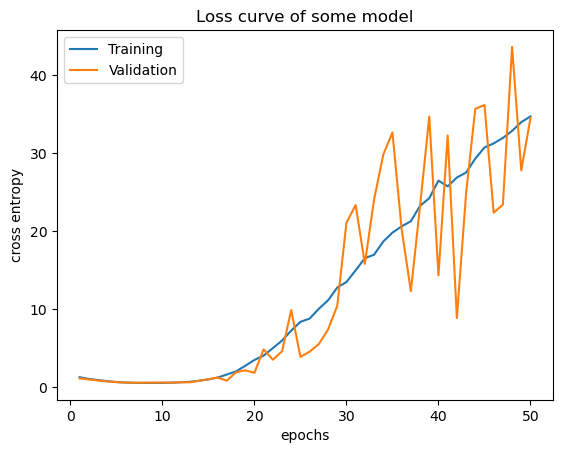

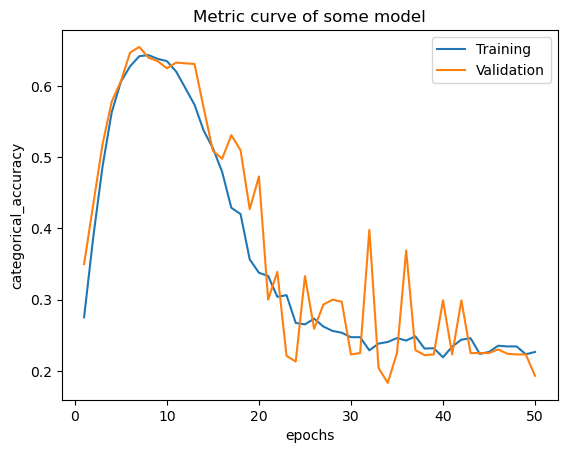

In [53]:
learning_curves(history)

In [48]:
mlp.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_15 (Bat  (None, 400)              1600      
 chNormalization)                                                
                                                                 
 dense_45 (Dense)            (None, 25)                10025     
                                                                 
 dense_46 (Dense)            (None, 25)                650       
                                                                 
 dense_47 (Dense)            (None, 5)                 130       
                                                                 
Total params: 12,405
Trainable params: 11,605
Non-trainable params: 800
_________________________________________________________________


In [58]:
print(y_one_hot)

tf.Tensor(
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]], shape=(5000, 5), dtype=float32)
